In [1]:
pip install torch transformers datasets pillow matplotlib

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.


In [2]:
# Import required Libraries

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.applications.xception import Xception
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from pickle import load

import os
import random

1/1 [==============================] - 1s 1s/step



start man in red shirt is walking along the street end


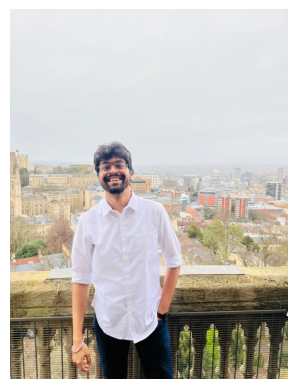

In [3]:
# Manually setting the image path  
img_path = r'C:\Users\User\Downloads\Phone Link\IMG-20231219-WA0018.jpg'
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        return None
    image = image.resize((299,299))
    image = np.array(image)
    if image.shape[2] == 4: 
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

max_length = 32
tokenizer = load(open("tokenizer.p", "rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
if photo is not None:
    img = Image.open(img_path)
    description = generate_desc(model, tokenizer, photo, max_length)
    print("\n\n")
    print(description)
    plt.axis('off')
    plt.imshow(img)
else:
    print("Feature extraction failed.")

1/1 [==============================] - 0s 244ms/step


C:\Users\User\AppData\Local\Temp\ipykernel_59548\539712204.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


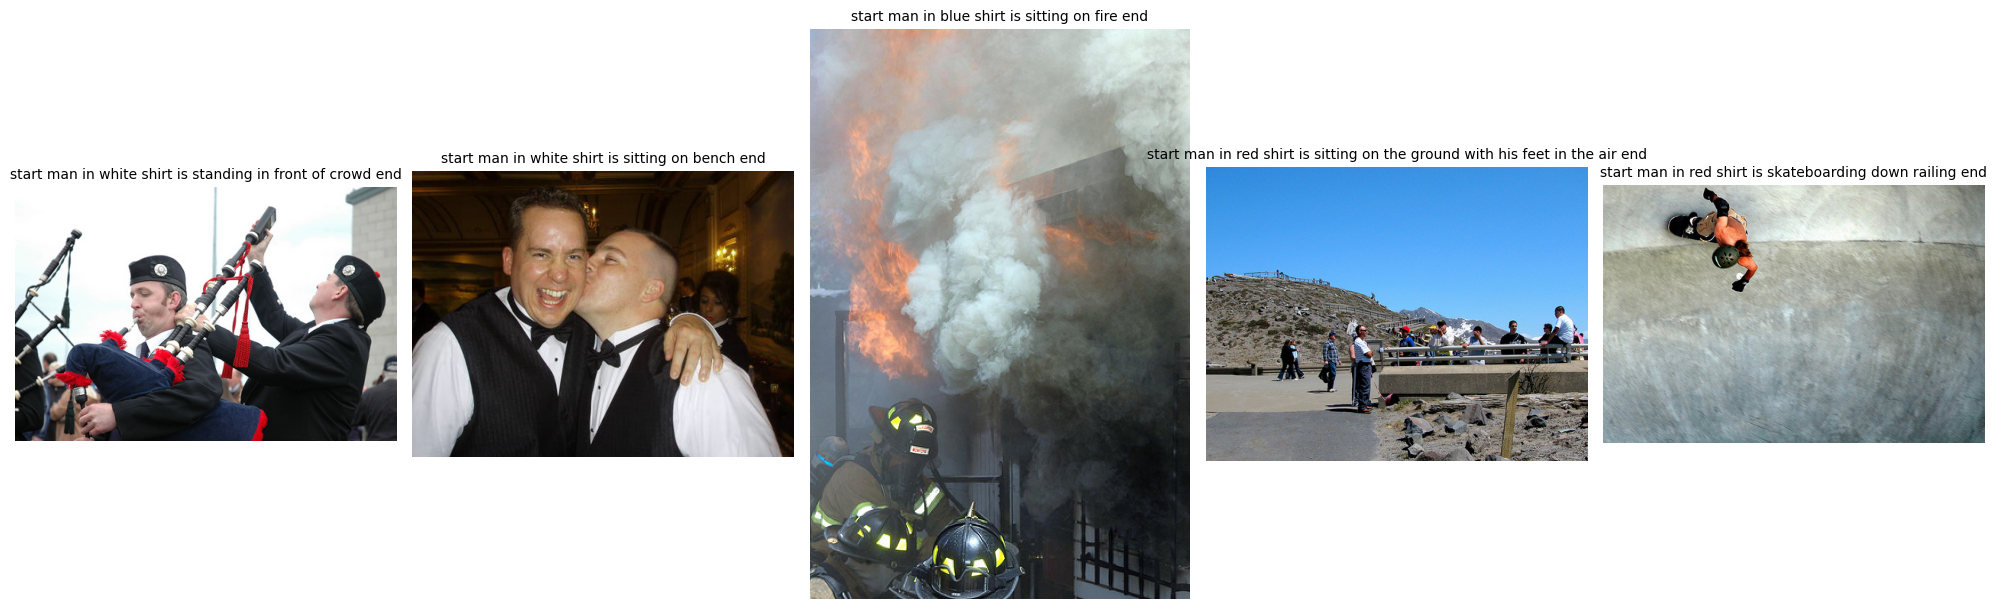

In [4]:


# Path to the dataset directory
image_dir = r'C:\Users\User\Workbooks\Dissertation\Flickr8k_Dataset\Flicker8k_Dataset'

def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        return None
    image = image.resize((299, 299))
    image = np.array(image)
    # Convert images that have 4 channels into 3 channels
    if image.shape[2] == 4: 
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

# Load tokenizer and model
max_length = 32
tokenizer = load(open("tokenizer.p", "rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

# Get all image paths from the directory
all_images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.jpg')]

# Randomly select 5 images
random_images = random.sample(all_images, 5)

# Set up subplot grid (e.g., 2x3 grid for 5 images)
fig, axes = plt.subplots(1, 5, figsize=(20, 6), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Process and display the images with their captions
for i, img_path in enumerate(random_images):
    photo = extract_features(img_path, xception_model)
    if photo is not None:
        img = Image.open(img_path)
        description = generate_desc(model, tokenizer, photo, max_length)
        
        # Display the image
        axes[i].imshow(img)
        axes[i].set_title(description, fontsize=10)
        axes[i].axis('off')  # Hide axes
    else:
        print(f"Feature extraction failed for image: {img_path}")

# Hide any unused subplot spaces
for j in range(len(random_images), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [5]:
pip install nltk pycocoevalcap

In [6]:
#Evaluation Metrics

import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

In [7]:
# Function to load image captions
def load_captions(captions_file):
    image_captions = {}
    with open(captions_file, 'r') as file:
        for line in file:
            parts = line.strip().split('#', 2)
            if len(parts) != 3:
                continue
            img_id, _, caption = parts
            if img_id not in image_captions:
                image_captions[img_id] = []
            image_captions[img_id].append(caption)
    return image_captions

# Function to evaluate the generated captions
def evaluate_captions(generated_captions, reference_captions):
    refs = [[ref.split() for ref in refs_for_image] for refs_for_image in reference_captions]
    hyps = [gen_caption.split() for gen_caption in generated_captions]
    assert len(hyps) == len(refs)

    # Apply smoothing function to BLEU score
    smoothing_function = SmoothingFunction().method4
    bleu_score = corpus_bleu(refs, hyps, smoothing_function=smoothing_function)

    # METEOR Score
    meteor = Meteor()
    meteor_score, _ = meteor.compute_score({i: [" ".join(ref) for ref in refs[i]] for i in range(len(refs))}, {i: [" ".join(hyps[i])] for i in range(len(hyps))})

    # ROUGE Score
    rouge = Rouge()
    rouge_score, _ = rouge.compute_score({i: [" ".join(ref) for ref in refs[i]] for i in range(len(refs))}, {i: [" ".join(hyps[i])] for i in range(len(hyps))})

    # CIDEr Score
    cider = Cider()
    cider_score, _ = cider.compute_score({i: [" ".join(ref) for ref in refs[i]] for i in range(len(refs))}, {i: [" ".join(hyps[i])] for i in range(len(hyps))})

    return bleu_score, meteor_score, rouge_score, cider_score

In [8]:
captions_file = r'C:\Users\User\Workbooks\Dissertation\Flickr8k_text\Flickr8k.token.txt' 
image_captions = load_captions(captions_file)

# Select 5 random images and their captions
random_image_files = random.sample(list(image_captions.keys()), 5)

# Generate captions for the selected images
generated_captions = []
reference_captions = []

for img_file in random_image_files:
    img_path = os.path.join(image_dir, img_file)
    photo = extract_features(img_path, xception_model)
    if photo is not None:
        generated_caption = generate_desc(model, tokenizer, photo, max_length)
        generated_captions.append(generated_caption)
        reference_captions.append(image_captions[img_file])

# Evaluate captions
bleu_score, meteor_score, rouge_score, cider_score = evaluate_captions(generated_captions, reference_captions)

1/1 [==============================] - 0s 175ms/step


In [9]:
print(f"BLEU Score: {bleu_score}")
print(f"METEOR Score: {meteor_score}")
print(f"ROUGE Score: {rouge_score}")
print(f"CIDEr Score: {cider_score}")

BLEU Score: 0.015443358192651808
METEOR Score: 0.056774076493495806
ROUGE Score: 0.09547889952441153
CIDEr Score: 0.3380543622504127
